In [1]:
import pandas as pd
import numpy as np
import json
import re

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as stopwords_nltk
stopwords_nltk = set(stopwords_nltk.words('english'))
from gensim.parsing.preprocessing import STOPWORDS as stopwords_gensim

import gensim
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim.corpora as corpora

import os
from os.path import join

from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/stas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def compute_coherence_values(corpus, id2word, topics_range, rs):
    coherence_values = []

    for num_topics in tqdm(topics_range):        
        model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=rs)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

In [4]:
def lemmatize_stemming(text):
#     return SnowballStemmer('english').stem(WordNetLemmatizer().lemmatize(text, pos='v'))
#     return SnowballStemmer('english').stem(text)
    return WordNetLemmatizer().lemmatize(text, pos='v')

In [5]:
stop_words = stopwords_nltk | stopwords_gensim
stop_words |= set(['python', 'pycharm'])

In [6]:
data = pd.read_json('pycharm_issues.json', lines=True)
data.head()

,idReadable,created,summary,description,Affected versions
0,PY-22135,1483471995465,"""Parameter foo unfilled"": false positives for ...","I'm getting false ""Incorrect call argument"" in...",[2016.3]
1,PY-22143,1483528763930,Python Extract Superclass: Incorrect Order of ...,"When extracting superclasses, if extractions i...",[2016.3]
2,PY-22145,1483545972098,Inspection does not report 'Unresolved Referen...,If a variable is deleted using the `del` state...,[2016.2]
3,PY-22149,1483572086024,ipython notebook clear_output() not working,"Below code should print only once ""Hellow Worl...",[]
4,PY-22128,1483387969625,False negative: no error for round brackets in...,I believe it's rather a common typo to use rou...,[2017.1]


In [7]:
data2 = data[[('2020.2' in el) for el in data['Affected versions']]].dropna()
data3 = data[[('2020.3' in el) for el in data['Affected versions']]].dropna()
data2.shape, data3.shape

((624, 5), (518, 5))

In [8]:
def get_popular_themes(model, corpus):
    popularity_by_text = [max(el, key=lambda x: x[1]) for el in model.get_document_topics(corpus)]
    return [(model.id2word[id_word], score) for id_word, score in popularity_by_text]

In [9]:
def process_data(data: pd.DataFrame, rs):    
    d = data.summary.tolist()
    data_by_words = [simple_preprocess(row, deacc=True) for row in d]
    data_by_words = [[lemmatize_stemming(word) for word in issue if word not in stop_words]for issue in data_by_words ]

    id2word = corpora.Dictionary(data_by_words)
    # id2word.filter_extremes(no_below=10, no_above=0.05)
    id2word.filter_extremes(no_below=2, no_above=0.5)
    texts = data_by_words
    corpus = [id2word.doc2bow(text) for text in texts]
    
    tfidf = TfidfModel(corpus, id2word=id2word)
    corpus_tfidf = tfidf[corpus]
    
    topics_range = range(2, 200, 20)
    u_mass = compute_coherence_values(corpus_tfidf, id2word, topics_range, 0)

    sns.set_theme(rc={"figure.figsize": (10, 5)})
    ax = sns.lineplot(x=topics_range, y=u_mass, label='zoom out')
    ax.set_title("Model coherence")
    ax.set_ylabel("Coherence value")
    ax.set_xlabel("Number of topics")
    
    topics_range = range(20, 75, 5)
    u_mass = compute_coherence_values(corpus_tfidf, id2word, topics_range, 0)

    sns.set_theme(rc={"figure.figsize": (10, 5)})
    ax = sns.lineplot(x=topics_range, y=u_mass, label='zoom in')
    ax.set_title("Model coherence")
    ax.set_ylabel("Coherence value")
    ax.set_xlabel("Number of topics")
    plt.show()
    
    num_topics = 50
    tfidf_model = LdaMulticore(corpus=corpus_tfidf,
                                             id2word=id2word,
                                             num_topics=num_topics,
                                             random_state=rs)


    topics = tfidf_model.show_topics(num_topics, 5, formatted=False)
    topics_names_only = [list(zip(*el[1]))[0] for el in topics]
    
    tfidf_coefs = sorted([(tfidf.id2word[el_id], el_coef) for el_id, el_coef in tfidf.idfs.items()], reverse=True)
    
    popular_themes = get_popular_themes(tfidf_model, corpus_tfidf)
    return topics_names_only, tfidf_coefs, popular_themes

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

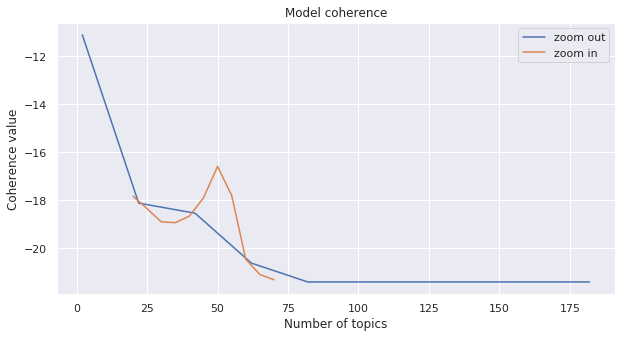

In [10]:
names2, tfidf_coefs2, popular_themes2 = process_data(data2, 7)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

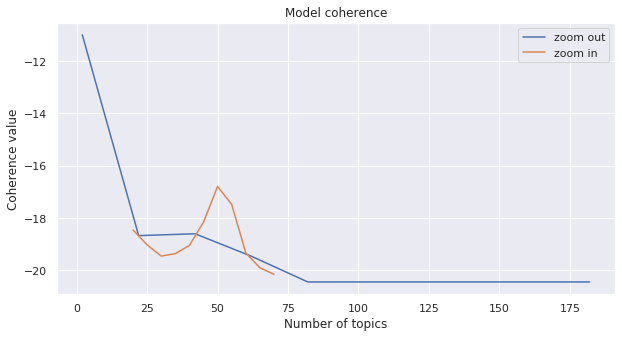

In [11]:
names3, tfidf_coefs3, popular_themes3 = process_data(data3, rs=7)

## Важное замечание
Я использую следующую терминологию:

"Документ" -- Текс, состоящий из предложений, в нашем issue 

"Топики" -- это набор "тем". "Темы" -- нормализованные слова из предложений документа

## Топики

Посмотрим на топики 2020.3 версии

In [12]:
names2

[('venv', 'interpreter', 'runtime', 'select', 'newly'),
 ('target', 'unused', 'assignment', 'fix', 'quick'),
 ('type', 'generic', 'positive', 'warn', 'explicit'),
 ('loop', 'connect', 'pro', 'create', 'error'),
 ('explicit', 'know', 'trigger', 'matplotlib', 'fail'),
 ('work', 'docstring', 'specify', 'cell', 'subprocess'),
 ('str', 'literal', 'get', 'lang', 'java'),
 ('dunder', 'keywords', 'positive', 'module', 'history'),
 ('try', 'block', 'twice', 'ubuntu', 'available'),
 ('set', 'annotations', 'hint', 'type', 'occurrences'),
 ('file', 'instal', 'instead', 'bool', 'comparison'),
 ('define', 'different', 'runner', 'bind', 'install'),
 ('set', 'type', 'deployment', 'toggle', 'add'),
 ('function', 'typo', 'match', 'extract', 'literal'),
 ('corrupt', 'report', 'quote', 'sdk', 'string'),
 ('linux', 'font', 'pro', 'default', 'unable'),
 ('support', 'space', 'unexpected', 'genericalias', 'recognize'),
 ('rest', 'request', 'escape', 'stop', 'properly'),
 ('signature', 'redeclared', 'unicode',

Посмотрим на топики 2020.3 версии

In [13]:
names3

[('skeleton', 'generator', 'stick', 'launch', 'upgrade'),
 ('close', 'window', 'refresh', 'shortcut', 'ignore'),
 ('pass', 'better', 'cython', 'render', 'output'),
 ('code', 'unreachable', 'paste', 'need', 'errors'),
 ('import', 'options', 'call', 'init', 'stub'),
 ('injection', 'markdown', 'code', 'work', 'host'),
 ('switch', 'js', 'txt', 'rename', 'work'),
 ('folder', 'application', 'root', 'templates', 'inside'),
 ('usage', 'consider', 'result', 'wrongly', 'level'),
 ('specify', 'input', 'directory', 'instead', 'warn'),
 ('django', 'package', 'import', 'common', 'aliases'),
 ('deployment', 'image', 'tag', 'suggestions', 'account'),
 ('env', 'miniconda', 'file', 'welcome', 'main'),
 ('child', 'parent', 'rename', 'row', 'paste'),
 ('tag', 'template', 'main', 'run', 'file'),
 ('window', 'service', 'run', 'ability', 'menu'),
 ('object', 'data', 'sciview', 'name', 'view'),
 ('django', 'generate', 'account', 'diagram', 'boolean'),
 ('work', 'stop', 'configure', 'negative', 'cause'),
 ('co

## TFIDF компоненты

Оценим, не произошло ли значимых изменений в tfidf компонентах тем, которые перешли из 2020.2 релиза в 2020.3. Такие темы могут сигнализировать о конкретной проблеме. Сейчас значительных изменений не заметно

In [14]:
d2 = pd.DataFrame(tfidf_coefs2, columns=['theme', '2020.2']).groupby('theme').median()
d3 = pd.DataFrame(tfidf_coefs3, columns=['theme', '2020.3']).groupby('theme').median()
tfidf_coefs = pd.merge(d2,d3, left_index=True, right_index=True)
tfidf_coefs['change'] = tfidf_coefs['2020.3'] - tfidf_coefs['2020.2']
tfidf_coefs[abs(tfidf_coefs.change) > 1.55].sort_values('change')

,2020.2,2020.3,change
theme,,,
column,8.285402,6.209453,-2.075949
block,7.700440,5.694880,-2.005560
templates,8.285402,6.431846,-1.853556
parameter,7.285402,5.431846,-1.853556
longer,8.285402,6.694880,-1.590522
namespace,8.285402,6.694880,-1.590522
select,8.285402,6.694880,-1.590522
structure,8.285402,6.694880,-1.590522
report,7.285402,5.694880,-1.590522


Теперь посмотрим на темы, которые исчезли с переходом в версию 2020.3. 

In [15]:
top_themes = d2.loc[set(d2.index)-set(d3.index)].sort_values('2020.2', ascending=False)
[(el.Index, np.round(el._1, 2)) for el in top_themes[top_themes['2020.2'] >= top_themes['2020.2'].median()].itertuples()]

[('second', 8.29),
 ('receive', 8.29),
 ('complain', 8.29),
 ('walrus', 8.29),
 ('occurrences', 8.29),
 ('dependency', 8.29),
 ('javascript', 8.29),
 ('keywords', 8.29),
 ('redeclared', 8.29),
 ('state', 8.29),
 ('end', 8.29),
 ('unwanted', 8.29),
 ('special', 8.29),
 ('space', 8.29),
 ('add_argument', 8.29),
 ('rst', 8.29),
 ('runner', 8.29),
 ('async', 8.29),
 ('callable', 8.29),
 ('flow', 8.29),
 ('unicode', 8.29),
 ('normal', 8.29),
 ('maya', 8.29),
 ('invoke', 8.29),
 ('augment', 8.29),
 ('facet', 8.29),
 ('binary', 8.29),
 ('database', 8.29),
 ('argparse', 8.29),
 ('actually', 8.29),
 ('english', 8.29),
 ('throwable', 8.29),
 ('definitions', 8.29),
 ('complex', 8.29),
 ('erroneously', 8.29),
 ('dot', 8.29),
 ('accept', 8.29),
 ('dirs', 8.29),
 ('comprehensions', 8.29),
 ('leak', 8.29),
 ('startup', 8.29),
 ('jcef', 8.29),
 ('pypi', 8.29),
 ('panel', 8.29),
 ('pytorch', 8.29),
 ('cmd', 8.29),
 ('comparison', 8.29),
 ('thread', 8.29),
 ('constructor', 8.29),
 ('popen', 8.29),
 ('di

И темы, которые появились в 2020.3. 

In [16]:
top_themes = d3.loc[set(d3.index)-set(d2.index)].sort_values('2020.3', ascending=False)
[(el.Index, np.round(el._1, 2)) for el in top_themes[top_themes['2020.3'] >= top_themes['2020.3'].median()].itertuples()]

[('shift', 8.02),
 ('env', 8.02),
 ('cfg', 8.02),
 ('super', 8.02),
 ('subclass', 8.02),
 ('directories', 8.02),
 ('concatenation', 8.02),
 ('register', 8.02),
 ('hello', 8.02),
 ('sequence', 8.02),
 ('slice', 8.02),
 ('markers', 8.02),
 ('mutable', 8.02),
 ('arguments', 8.02),
 ('uninstall', 8.02),
 ('real', 8.02),
 ('require', 8.02),
 ('self', 8.02),
 ('int', 8.02),
 ('peer', 8.02),
 ('reader', 8.02),
 ('forever', 8.02),
 ('plain', 8.02),
 ('unreachable', 8.02),
 ('await', 8.02),
 ('injection', 8.02),
 ('npe', 8.02),
 ('post', 8.02),
 ('regression', 8.02),
 ('tip', 8.02),
 ('clear', 8.02),
 ('apple', 8.02),
 ('ast', 8.02),
 ('scratch', 8.02),
 ('collections', 8.02),
 ('inspections', 8.02),
 ('insight', 8.02),
 ('statements', 8.02),
 ('bold', 8.02),
 ('selection', 8.02),
 ('backend', 8.02),
 ('service', 8.02),
 ('welcome', 8.02),
 ('pyqt', 8.02),
 ('clause', 8.02),
 ('suggestions', 8.02),
 ('poetry', 8.02),
 ('concurrency', 8.02),
 ('virtual', 8.02),
 ('miniconda', 8.02),
 ('vagrant',

Теперь посмотрим на темы в разрезе ``популярности``, то есть того, насколько выраженны темы в топкиках.
Опять начнем с тем, которые перешли из релиза в релиз

In [17]:
d2 = pd.DataFrame(popular_themes2, columns=['theme', '2020.2']).groupby('theme').median()
d3 = pd.DataFrame(popular_themes3, columns=['theme', '2020.3']).groupby('theme').median()
popular_themes = pd.merge(d2,d3, left_index=True, right_index=True)
popular_themes['change'] = popular_themes['2020.3'] - popular_themes['2020.2']
popular_themes.sort_values('change')

,2020.2,2020.3,change
theme,,,
import,0.559584,0.457215,-0.102369
false,0.401666,0.312405,-0.089261
project,0.411476,0.352581,-0.058895
raise,0.350885,0.324006,-0.026879
class,0.455778,0.431507,-0.024271
django,0.423989,0.418944,-0.005045
string,0.421270,0.469210,0.047939
positive,0.261207,0.401177,0.139970


Посмотрим на те, которые исчезли с переходом на 2020.3

In [18]:
d2.loc[set(d2.index)-set(d3.index)].sort_values('2020.2', ascending=False).head(15)

,2020.2
theme,
exception,0.640884
number,0.602300
include,0.566836
data,0.507051
local,0.505408
directory,0.499870
global,0.491067
template,0.489946
break,0.488495


И которые появились в версии 2020.3.
Можно заметить странную активность вокруг pytest'a и джавы, нужно обратить на это внимание.

In [19]:
d3.loc[set(d3.index)-set(d2.index)].sort_values('2020.3', ascending=False).head(15)

,2020.3
theme,
unused,0.733980
pytest,0.710663
infer,0.590552
helpers,0.560713
setup,0.507869
detect,0.506023
requirements,0.491492
step,0.459521
expect,0.457077
